**Automatic Port Operations with Image Recognition using a Convolutional Neural Network**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile


zip_ref = ZipFile('/content/drive/MyDrive/DL/boats.zip','r')
zip_ref.extractall('/content/drive/MyDrive/DL')
zip_ref.close()

In [2]:
# lets define some constants
boats_dir = '/content/drive/MyDrive/DL/TRAIN_BOATS'

height = 180
width = 180
batch_size = 32

In [3]:
import pathlib
data_dir = pathlib.Path(boats_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1162


In [7]:
# using the latest tf.data for efficient input pipelines
#https://www.tensorflow.org/guide/data

import tensorflow as tf
def get_ds(data_dir,validation_split=0.2,subset='training',seed = 43,image_size=(255,255),batch_size=32):
    train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=validation_split,
    subset=subset,
    seed=seed,
    image_size=image_size,
    batch_size=batch_size)
    train_ds.class_names
    return train_ds

train_ds = get_ds(data_dir,image_size=(height,width),batch_size=batch_size)

Found 1162 files belonging to 9 classes.
Using 930 files for training.


In [8]:
val_ds = get_ds(data_dir,validation_split=0.2,subset='validation',seed = 43,image_size=(height,width),batch_size=batch_size)

Found 1162 files belonging to 9 classes.
Using 232 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['buoy', 'cruise_ship', 'ferry_boat', 'freight_boat', 'gondola', 'inflatable_boat', 'kayak', 'paper_boat', 'sailboat']


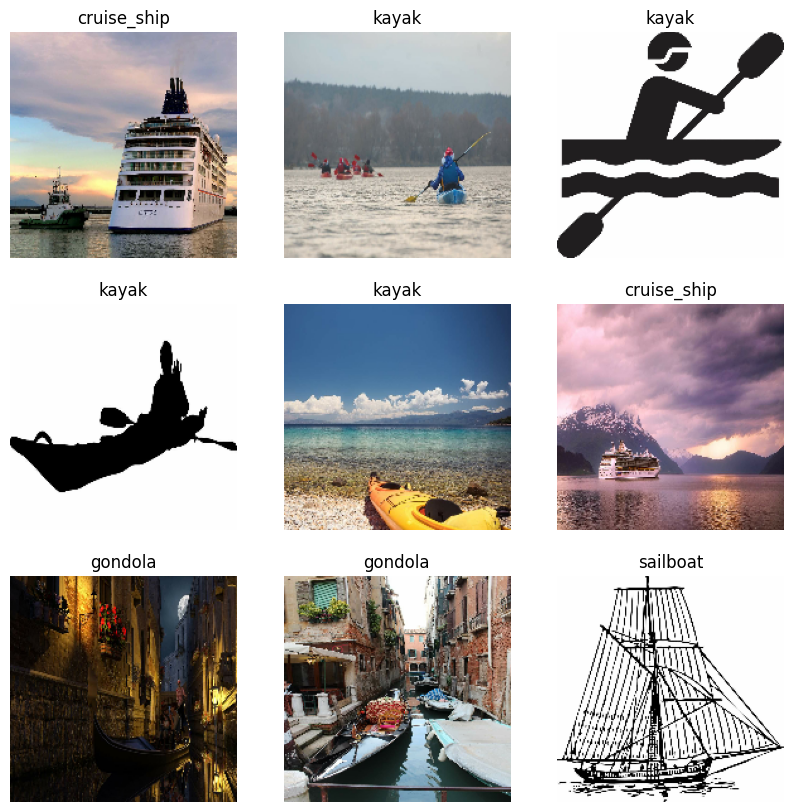

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

https://www.tensorflow.org/guide/data_performance

Using cache, prfetch and AUTOTUNE for efficient handling of input data

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# import library
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential([
  ##--- starting data augmenttaion
  layers.RandomFlip("horizontal",input_shape=(height,width,3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  ##---- Data Augmentation ends
  layers.Rescaling(1./255, input_shape=(height, width, 3)), #Scale the pixels
  layers.Conv2D(32, (3,3), padding='same', activation='relu'), # convolutiion with 16 fillters with a 3x3 kernal matrix
  layers.MaxPooling2D(), # Use max pooling

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),


  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.GlobalMaxPooling2D(),
  layers.Dropout(0.2),

  layers.Flatten(), # flatten the input for feeding to ANN
  layers.Dense(128, activation='relu'), # ANN hidde layer with 128 neurons
  layers.Dense(len(class_names)) # ANN output layer

])
# comple the model
model.compile(optimizer='adam',
              # Recomended for sparse matrix data ( which images are)
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              #could not find a way to add precision and recall. Adding them fails in training !
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,169 (469.41 KB)

 Trainable params: 120,169 (469.41 KB)

 Non-trainable params: 0 (0.00 B)

Using early stopping and checkpoint to stop training as I have very limited GPU resources

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

class MyCheckpoint(ModelCheckpoint):

    def __init__(self,
                 filepath,
                 monitor="val_loss",
                 verbose=0,
                 save_best_only=False,
                 save_weights_only=False,
                 mode="auto",
                 save_freq="epoch",
                 initial_value_threshold=None,
                 ):
        super().__init__(filepath,
                         monitor,
                         verbose,
                         save_best_only,
                         save_weights_only,
                         mode,
                         save_freq,
                         initial_value_threshold)

        self.last_epoch_number = 0

    def on_epoch_end(self,epoch,logs=None):
        super().on_epoch_end(epoch,logs)
        self.last_epoch_number =  epoch
        print(f'epoch {epoch} completed')


In [14]:
from tensorflow.keras.callbacks import EarlyStopping


early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,min_delta=0.01)
checkpoint=MyCheckpoint('best_model.keras',monitor='val_loss',mode='min',verbose=1,save_best_only=True)

epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size = batch_size,
  # not specified. But i thought this was a good idea
  callbacks = [early_stop,checkpoint]
)

Epoch 1/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2954 - loss: 1.9436
Epoch 1: val_loss improved from inf to 1.87663, saving model to best_model.keras
epoch 0 completed
30/30 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.2958 - loss: 1.9398 - val_accuracy: 0.3017 - val_loss: 1.8766
Epoch 2/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3384 - loss: 1.8202
Epoch 2: val_loss improved from 1.87663 to 1.80234, saving model to best_model.keras
epoch 1 completed
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3386 - loss: 1.8211 - val_accuracy: 0.3017 - val_loss: 1.8023
Epoch 3/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3258 - loss: 1.8276
Epoch 3: val_loss did not improve from 1.80234
epoch 2 completed
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3270 - loss: 1.8267 - val_accuracy: 0.3017 - val_loss: 1.8309
Epoch 4/100
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3450 - loss: 1.8000
Epoch 4: val_loss did not improve from 1.

In [15]:
# print training accuracy


score_test = model.evaluate(val_ds, verbose=0)
print('Test loss:', score_test[0])
print('Test accuracy:', score_test[1])
score_train= model.evaluate(train_ds, verbose=0)
print('Train loss:', score_train[0])
print('train accuracy:', score_train[1])


Test loss: 1.2602171897888184
Test accuracy: 0.6551724076271057
Train loss: 0.6432363390922546
train accuracy: 0.7881720662117004


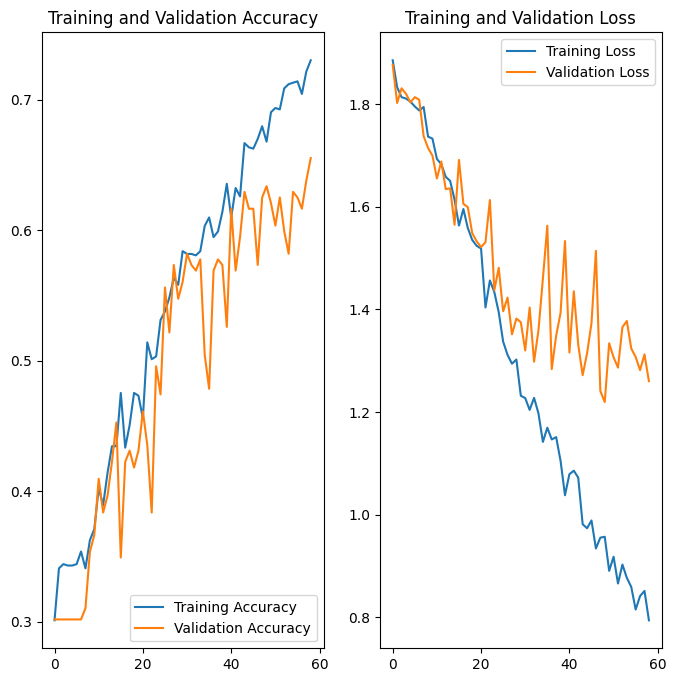

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(checkpoint.last_epoch_number+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

There is a bit or overfitting, though a small one. I will not fine tune further b/c of scarsce GPU resources

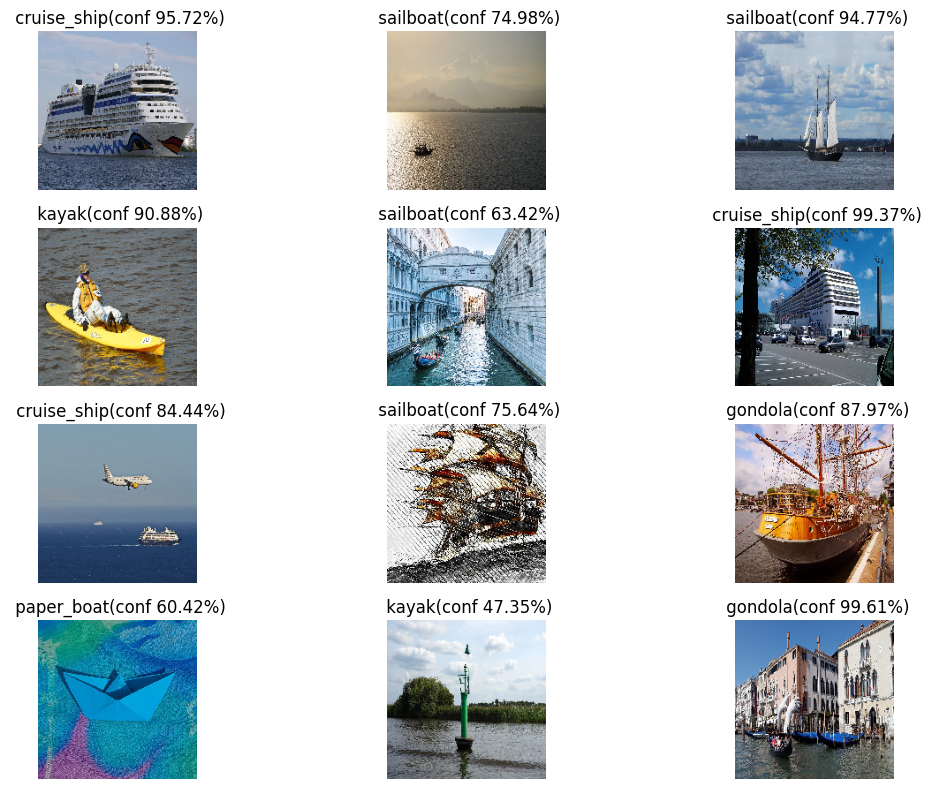

In [18]:

import numpy as np
import pprint

test_dir = '/content/drive/MyDrive/DL/TEST_BOATS/all'

images = [
          test_dir+'/101.jpg',
          test_dir+'/102.jpg',
          test_dir+'/104.jpg',
          test_dir+'/105.jpg',
          test_dir+'/106.jpg',
          test_dir+'/107.jpg',
          test_dir+'/111.jpg',
          test_dir+'/119.jpg',
          test_dir+'/121.jpg',
          test_dir+'/139.jpg',
          test_dir+'/141.jpg',
          test_dir+'/144.jpg',
          ]

plt.figure(figsize = (12,8))
for i,path in enumerate(images):

  img = tf.keras.utils.load_img(
      path, target_size=(height, width)
  )


  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array,verbose=False)
  score = tf.nn.softmax(predictions[0])
  plt.subplot(4,3,i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(
      " {}(conf {:.2f}%)"
      .format(class_names[np.argmax(score)], 100 * np.max(score)))
plt.tight_layout()
plt.show()

In [20]:
from sklearn.metrics import confusion_matrix
true_lables = []
predicted_labels = []
for images, labels in train_ds.take(9): # we have 9 batches of 32 images each
  true_lables.extend(labels)
  for i in range(batch_size): # prediction for each image in the batch
      img_array = tf.keras.utils.img_to_array(images[i])
      img_array = tf.expand_dims(img_array, 0) # Create a batch
      predictions= model.predict(img_array,verbose=False)
      score = tf.nn.softmax(predictions[0])
      predicted_labels.append(np.argmax(score))
# True and predicted labels should match
assert(len(true_lables) == len(predicted_labels))
print(len(true_lables),len(predicted_labels))


288 288


Confusion Matrix
[[ 5  0  0  0  2  0  2  0  2]
 [ 0 34  1  0  0  0  1  0  4]
 [ 0  5  1  0  2  0  3  0  3]
 [ 0  1  0  2  1  0  0  0  1]
 [ 0  0  0  0 47  0  1  0  0]
 [ 0  0  0  0  0  1  0  0  2]
 [ 0  3  0  0  1  0 47  0  4]
 [ 0  0  1  0  0  0  0  5  1]
 [ 0  2  0  0  7  0  3  0 93]]

Confusion Matrix Displayed



<Figure size 1000x1000 with 0 Axes>

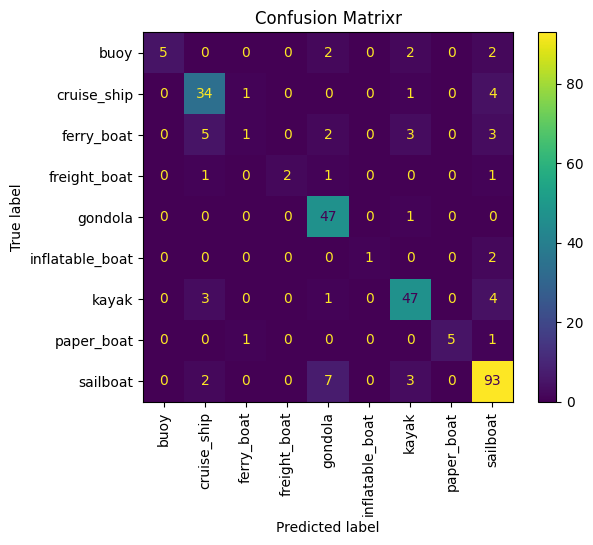

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(true_lables,predicted_labels)
print('Confusion Matrix')
print(cm)
print()

print('Confusion Matrix Displayed\n')
plt.figure(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()
plt.title('Confusion Matrixr')
plt.xticks(rotation=90)
plt.show()

In [22]:
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

cl_report = classification_report(true_lables,predicted_labels)
print(cl_report)

              precision    recall  f1-score   support

           0       1.00      0.45      0.62        11
           1       0.76      0.85      0.80        40
           2       0.33      0.07      0.12        14
           3       1.00      0.40      0.57         5
           4       0.78      0.98      0.87        48
           5       1.00      0.33      0.50         3
           6       0.82      0.85      0.84        55
           7       1.00      0.71      0.83         7
           8       0.85      0.89      0.87       105

    accuracy                           0.82       288
   macro avg       0.84      0.62      0.67       288
weighted avg       0.81      0.82      0.80       288



In [23]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
print('imported')

imported


In [24]:
mob_model = tf.keras.applications.MobileNet(
    input_shape=(height,width,3),
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    name='MobileNet',
)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [25]:
mob_model.summary()

Model: "MobileNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 90, 90, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 90, 90, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 90, 90, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 90, 90, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 90, 90, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 90, 90, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 91, 91, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 45, 45, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 45, 45, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 45, 45, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 45, 45, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 45, 45, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 45, 45, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 45, 45, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)